In [1]:
import supervisely_lib as sly
import cv2
from Layer import Layer
import layers
import os.path as osp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Now we need to create config for 3 dtl layers
# Configuration files are taken from the documentation
# For example, for crop layer: https://docs.enterprise.supervise.ly/export/crop/
crop_settings = {
  "action": "crop",
  "src": ["$data1"],
  "dst": "$data2",
  "settings": {
    "sides": {
      "top":"30%",
      "left":"100px",
      "right":"100px",
      "bottom":"0px"
    }
  }
}
flip_settings = {
  "action": "flip",
  "src": ["$data1"],
  "dst": "$data2",
  "settings": {
    "axis": "vertical"
  }
}
inst_crop_settings = {
  "action": "instances_crop",
  "src": [
    "$sample"
  ],
  "dst": "$sample1",
  "settings": {
    "classes": [
      "Car"
    ],
    "pad": {
      "sides": {
        "top": "10%",
        "left": "10%",
        "right": "10%",
        "bottom": "10%"
      }
    }
  }
}

In [3]:
# Dtl-layer initialization
# Layers classes are implemented in supervisely lib
crop_layer = layers.processing.CropLayer.CropLayer(crop_settings)
flip_layer = layers.processing.FlipLayer.FlipLayer(flip_settings)
inst_crop_layer = layers.processing.InstancesCrop.InstancesCropLayer(inst_crop_settings)

In [4]:
# Any supervisely programm contain folders: "model", "result", "data", "tmp". Also, it has file task_settings.json
task_paths = sly.TaskPaths() # now task_paths contain paths to all this folders and file
project_dir = task_paths.project_dir
# Any folder "data" contain project with images and some meta information in file meta.json
project_meta = sly.ProjectMeta.from_dir(project_dir) # read info from meta.json

In [5]:
# meta.json contain info about classes in annotations of images
# including a color corresponding to each class 
color_mapping = {} # this variable will contain a mapping class->color
for cls_descr in project_meta.classes:
    color_s = cls_descr.get('color')
    if color_s is not None:
        color = sly.hex2rgb(color_s)  # use color from project meta if exists
    else:
        color = sly.get_random_color()  # or use random color otherwise
    color_mapping[cls_descr['title']] = color

In [6]:
# Now we need to load images with there annotations
fs = sly.ProjectFS.from_disk(*sly.ProjectFS.split_dir_project(project_dir))
# And create an output project structure 'project_augmentations'
out_pr_structure = sly.ProjectStructure('project_augmentations')

In [7]:
# Add items to output project structure
# Each item contain info about dataset_name and some service information
# about images and annotations
for sample_info in fs:
    sample_data = sample_info.ia_data
    dt = {
        'src_img_path': sample_info.img_path,
        'ann_img_path': sample_info.ann_path,
        **sample_data
    }
    out_pr_structure.add_item(sample_info.ds_name, sample_info.image_name, dt)

In [8]:
# Using output projects structure `out_pr_structure` we create
#  folders corresponding to this structure
out_pr_fs = sly.ProjectFS(task_paths.results_dir, out_pr_structure)
out_pr_fs.make_dirs()

In [9]:
# Auxiliary function for drawing objects from the annotation
def draw_obj(img,new_ann, color_mapping):
    for obj in new_ann['objects']:
        obj.draw(img, color_mapping[obj.data['classTitle']])

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


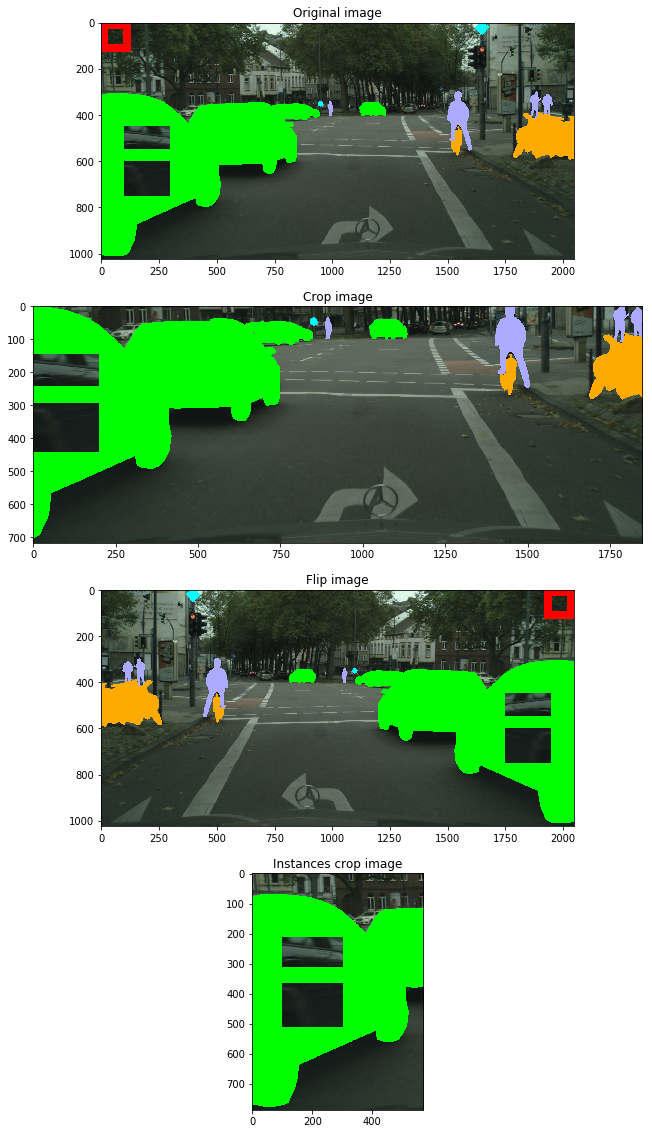

In [10]:
# Loop throw output project file structure
for s in out_pr_fs:
    plt.figure(figsize=(20, 20))
    sly.copy_file(s.ia_data['src_img_path'], s.img_path) # Copy source image from data-directory
    sly.copy_file(s.ia_data['ann_img_path'], s.ann_path) # Copy source annotation from data-directory
    img_name, img_ext = osp.splitext(s.img_path)
    img_desc = sly.ImageDescriptor(s) # Get image description
    img = img_desc.read_image() # Get image
    ann_name, ann_ext = osp.splitext(s.ann_path)
    ann_packed = sly.json_load(s.ann_path)
    ann = sly.Annotation.from_packed(ann_packed, project_meta) # Unpack annotation
    draw_obj(img, ann, color_mapping)
    ax = plt.subplot(4, 1, 1)
    ax.set_title('Original image')
    plt.imshow(img) # Draw source image
    data_el = (img_desc, ann) # Create data for dtl-layers
    # Applying dtl-layers to image
    cropped_img = crop_layer.process(data_el)
    flipped_img = flip_layer.process(data_el)
    inst_crop_img = inst_crop_layer.process(data_el)
    # Draw the results of cropping the image
    for new_img_desc, new_ann in cropped_img:
        new_img_desc.write_image_local(img_name + "_crop" + img_ext)
        img = new_img_desc.read_image()
        sly.json_dump(new_ann.pack(), ann_name + "_crop" + ann_ext)
        draw_obj(img, new_ann, color_mapping)
        ax = plt.subplot(4, 1, 2)
        ax.set_title('Crop image')
        plt.imshow(img)
    # Draw the results of flipping the image
    for new_img_desc, new_ann in flipped_img:
        new_img_desc.write_image_local(img_name + "_flip" + img_ext)
        img = new_img_desc.read_image()
        sly.json_dump(new_ann.pack(), ann_name + "_flip" + ann_ext)
        draw_obj(img, new_ann, color_mapping)
        ax = plt.subplot(4, 1, 3)
        ax.set_title('Flip image')
        plt.imshow(img)
    # Draw the results of inst_cropping the image
    for new_img_desc, new_ann in inst_crop_img:
        new_img_desc.write_image_local(img_name + "_inst_crop" + img_ext)
        img = new_img_desc.read_image()
        sly.json_dump(new_ann.pack(), ann_name + "_inst_crop" + ann_ext)
        draw_obj(img, new_ann, color_mapping)
        ax = plt.subplot(4, 1, 4)
        ax.set_title('Instances crop image')
        plt.imshow(img)
    plt.show()